In [ ]:
!mkdir ~\.kaggle

In [ ]:
!cd ~\.kaggle && ls

In [ ]:
!kaggle competitions download -c petfinder-pawpularity-score

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.config.run_functions_eagerly(False)


In [3]:
#import af libaries
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import tensorflow_addons as tfa
from PIL import Image
import imagehash
import imageio
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers



In [6]:
#test is not working i need to have a look at the download again
train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')
print("Amount of tranning's data: " + str(len(train)))
#print("Amount of test data: " + str(len(test)))
image_size = 224


Amount of tranning's data: 9912


In [7]:
#Loading images
def get_train_file_path(image_id):
    return r"C:\Users\tobia\GitHub\PetFinder\train\{}.jpg".format(image_id)

def get_test_file_path(image_id):
    return r"C:\Users\tobia\GitHub\PetFinder\test\{}.jpg".format(image_id)

train['file_path'] = train['Id'].apply(get_train_file_path)
#test['file_path'] = test['Id'].apply(get_test_file_path)


# Shows the first 5, change the paramter for more
display(train.head())


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,C:\Users\tobia\GitHub\PetFinder\train\0007de18...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,C:\Users\tobia\GitHub\PetFinder\train\0009c66b...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,C:\Users\tobia\GitHub\PetFinder\train\0013fd99...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,C:\Users\tobia\GitHub\PetFinder\train\0018df34...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,C:\Users\tobia\GitHub\PetFinder\train\001dc955...


In [ ]:
#Visualizing the spread??
train.hist(figsize=(15,15))
plt.tight_layout()
plt.show()

In [ ]:
#Mean of Pawpularity remove [] if you want the see mean on everything
print("Mean value of train "+ str(train['Pawpularity'].mean()))
train.info()

In [ ]:
#Kinda slow might be a faster way to do it.
#It gets height and width of each image and then calculate the aspect ratio
widths = []
heights = []
ratios = []
for file_path in tqdm(train['file_path']):
    image = imageio.imread(file_path)
    h, w, _ = image.shape
    heights.append(h)
    widths.append(w)
    ratios.append(w / h)

In [ ]:
#First we plot it to see the values
plt.figure(figsize=(15,8))
plt.title(f'Height and Width', size=24)
plt.hist(heights, bins=32, label='Heights')
plt.hist(widths, bins=32, label='Widths')
plt.legend(prop={'size': 16})
plt.show()

In [ ]:
#https://www.kaggle.com/markwijkhuizen/petfinder-eda-yolov5-obj-detection-tfrecords#Image-EDA
display(pd.Series(ratios).describe())
plt.figure(figsize=(15,8))
plt.title(f'Ratios', size=24)
plt.hist(ratios, bins=15, label='Ratios')
plt.legend(prop={'size': 15})
plt.show()

In [ ]:
#Hard to see the coalition on the ???bar??? graph so we create a scatter point graph
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(widths, heights, color='blue', alpha=0.5, s=ratios, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

In [ ]:
#Shows 5x5 images and their title is their paw score
plt.figure(figsize=(20, 20))
for i in range(5 * 5):
    plt.subplot(5, 5, i+1)
    image = plt.imread(train.iloc[i, -1])
    #image = plt.cvtColor(image, cv2.COLOR_BGR2RGB)
    Pawpularity = train.iloc[i, -2]
    plt.imshow(image)
    plt.title(f"Pawpularity Score: {Pawpularity}")
plt.show()

In [ ]:
#ligner der er duplicates som skal fjernes 
#https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/278497 kode til at fjerne dem findes her
tqdm.pandas()
def get_hash(file_path):
    img = Image.open(file_path)
    img_hash = imagehash.phash(img)
    
    return img_hash.hash.reshape(-1).astype(np.uint8)
    
train['phash'] = train['file_path'].progress_apply(get_hash)

In [ ]:
def find_similar_images(threshold=0.90):
    # Number of Duplicate Images Found
    duplicate_counter = 1
    # Indices of Duplicate Images
    duplicate_idxs = set()
    # For each image in the train dataset
    for idx, phash in enumerate(tqdm(train['phash'])):
        # Compute the similarity to all other images
        for idx_other, phash_other in enumerate(train['phash']):
            # Similarity score is imply the percentage of equal bits
            similarity = (phash ==phash_other).mean()
            # Prevent self comparison, threshold similarity and ignore repetetive duplicate detection
            if idx != idx_other and similarity > threshold and not(duplicate_idxs.intersection([idx, idx_other])):
                # Update Duplicate Indices
                duplicate_idxs.update([idx, idx_other])
                # Get DataFrame rows
                row = train.loc[idx]
                row_other = train.loc[idx_other]
                # Plot Duplicate Images
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
                ax[0].imshow(imageio.imread(row['file_path']))
                ax[0].set_title(f'Idx: {idx}, Pawpularity: {row["Pawpularity"]}')
                ax[1].imshow(imageio.imread(row_other['file_path']))
                ax[1].set_title(f'Idx: {idx_other}, Pawpularity: {row_other["Pawpularity"]}')
                plt.suptitle(f'{duplicate_counter} | PHASH Similarity: {similarity:.3f}')
                plt.show()
                # Increase Duplicate Counter
                duplicate_counter += 1
                
    # Return Indices of Duplicates
    return duplicate_idxs
    
duplicate_idxs = find_similar_images()
#The same images don't have the same paw score. The majority's paw score's diffrence is around 10.
#But some got over double the score'

In [ ]:
print(f'Found {len(duplicate_idxs)} Duplicate Images')
# Removing Duplicate Images, 
#Code taken from https://www.kaggle.com/markwijkhuizen/petfinder-eda-yolov5-obj-detection-tfrecords#Image-EDA
#IMPORTANT(I think so atleast)! If this code is run twice it will drop both images instead of just one of the duplicates
#Hhich image is correct one? They got diffrent scores
train = train.drop(duplicate_idxs).reset_index(drop=True)
print("Amount of tranning's data: " + str(len(train)))

In [ ]:
# Shows a batch of images we will use this function to see the lowest and highest pawpularity
def show_batch_df(df, rows=6, cols=4):
    df = df.copy().reset_index()
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*4, rows*4))
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            img = imageio.imread(df.loc[idx, 'file_path'])
            plt.imshow(img)
            axes[r, c].set_title(f'{idx}, label: {df.loc[idx, "Pawpularity"]}')
            


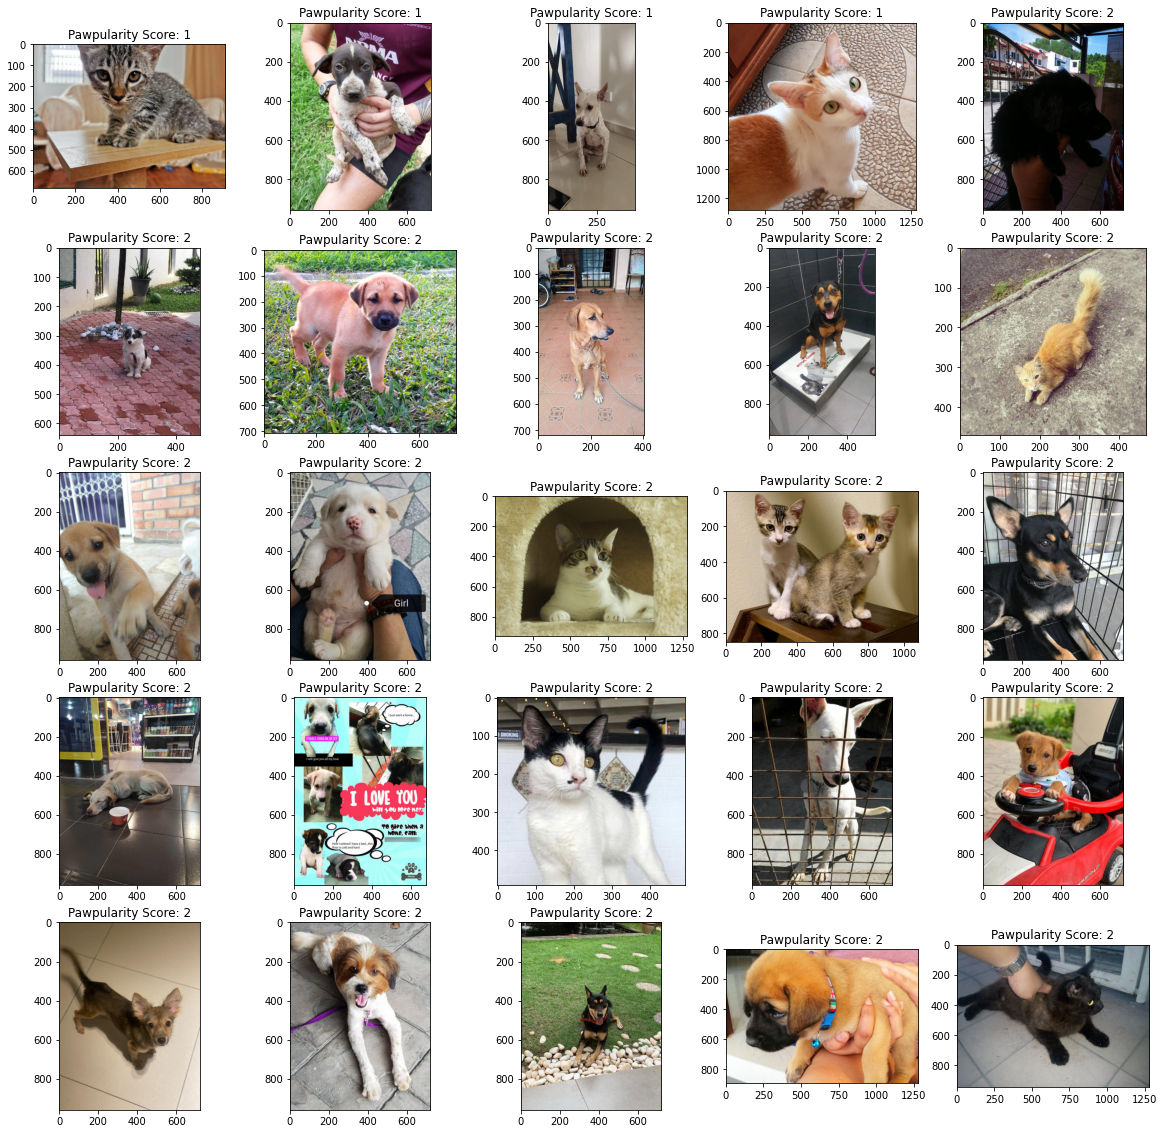

In [8]:
#Images with the lowest value
sorted_lowest = (train.sort_values('Pawpularity'))
plt.figure(figsize=(20, 20))
for i in range(5 * 5):
    plt.subplot(5, 5, i+1)
    image = plt.imread(sorted_lowest.iloc[i, -1])
    Pawpularity = sorted_lowest.iloc[i, -2]
    plt.imshow(image)
    plt.title(f"Pawpularity Score: {Pawpularity}")
plt.show()

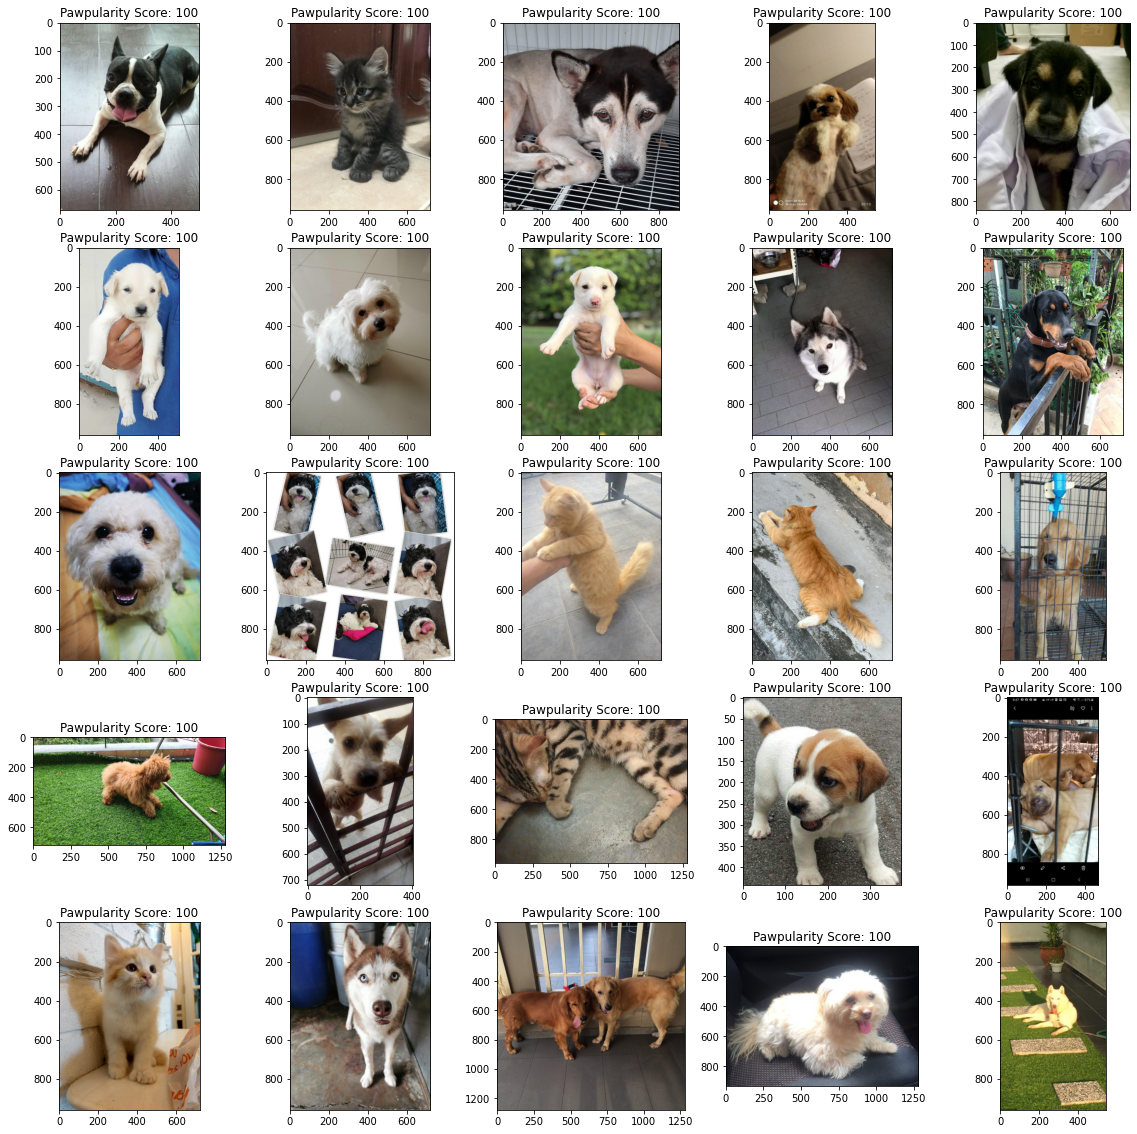

In [9]:
#Images with the highest value
sorted_highest = (train.sort_values('Pawpularity',ascending=False))
plt.figure(figsize=(20, 20))
for i in range(5 * 5):
    plt.subplot(5, 5, i+1)
    image = plt.imread(sorted_highest.iloc[i, -1])
    Pawpularity = sorted_highest.iloc[i, -2]
    plt.imshow(image)
    plt.title(f"Pawpularity Score: {Pawpularity}")
plt.show()

In [10]:
#We need some more preproccsing and data normalization
def dataNormalization(image):
    image = Image.open(image)
    #tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.reshape(image, [352, 352, 3])
    image = tf.image.resize(image, (image_size, image_size))
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [11]:
#train['file_path'] = train['file_path'].apply(dataNormalization)
#image = plt.imread(train.loc[0,'file_path'])
#ds = tf.data.Dataset.from_tensor_slices(dict(train))
AUTOTUNE = tf.data.experimental.AUTOTUNE

#opdel i test og train
train, test = train_test_split(train, test_size=0.2)
print("Amount of tranning's data: " + str(len(train)))
print("Amount of test data: " + str(len(test)))

train_dataset = train['file_path'].map(dataNormalization)
test_dataset = test['file_path'].map(dataNormalization)


Amount of tranning's data: 7929
Amount of test data: 1983


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
#checks if the values are normalized
#print(train_dataset[0])
#we need proper names here
train_pred = train.loc[:,'Pawpularity']
test_pred = test.loc[:,'Pawpularity']


In [ ]:
print(train_pred)
#type(pred)
#result = pd.merge(train_dataset, pred, left_on=None)
#train_dataset = pd.merge(train_dataset, train_pred, left_index=True, right_index=True)
#test_dataset = pd.merge(test_dataset, test_pred, left_index=True, right_index=True)

In [ ]:
print(train_dataset)

In [ ]:
display(train_dataset.head())

#print(train_dataset['file_path'])
#display(result.head())

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(5 * 5):
    plt.subplot(5, 5, i+1)
    plt.title('Original image')
    image =  train_dataset.iloc[i]
    plt.imshow(image)
plt.show(block=False)

In [ ]:
#Side by side comparrison with the new ratio
for i in range(5 * 5):
    result_image = train_dataset.iloc[i]
    train_image = plt.imread(train.iloc[i,-1])
    visualize(train_image,result_image)

In [ ]:
def augment(augmented):
    # We need to test with the diffrent type of augment to see if they hurt the acc. 
    # We should also take some of the fuctions we used in CNN
    augmented = tf.image.random_brightness(augmented, 0.05)
    augmented = tf.image.random_flip_left_right(augmented)
    augmented = tf.image.random_saturation(augmented, 0.95, 1)
    augmented = tf.image.random_contrast(augmented, 0.95, 1)
    augmented = tf.image.random_hue(augmented, 0.05)
    augmented = shear(augmented)
    return augmented

def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    
def shear(image):
    #shear
    #de her værdier skal nok ændres i
    random_number_shear = random.uniform(-0.2,0.2)
    shear = random_number_shear
    shear_rotate = shear * -20
    image = tfa.image.transform(image, [1.0, shear, shear_rotate, 0.0, 1.0, 0.0, 0.0, 0.0])
    return image

def crop(image):
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, img_height + 6, img_width + 6) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[img_height, img_width, 1])
    return image

In [ ]:
for i in range(3):
    image = train_dataset.iloc[i]
    changed_image = augment(image)
    visualize(image,changed_image)

In [ ]:
#First model
model = tf.keras.models.Sequential([
layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Dropout(0.25),
layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Dropout(0.25),
layers.Flatten(),
layers.Dense(units=1024, activation='relu'),
layers.Dropout(0.50),
layers.Dense(units=1,activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.losses.MeanSquaredError(),
  metrics=['accuracy'])

In [ ]:
#print(train_dataset.shape)
#print(test_dataset.shape)
#print(train_dataset)
def labelNormalize(value):
    return value/100;
#train_pred = train_pred.map(labelNormalize)
#test_pred = test_pred.map(labelNormalize)

print(train_pred)
#test_dataset.dtypes
X = np.array(train_dataset.tolist())
Y = np.array(train_dataset.tolist())

#clf.fit(test_dataset[0].tolist(), labels)
#np.array(test_dataset).astype("float32")


In [ ]:
print(train_dataset)

In [ ]:
type(X)
#tf.convert_to_tensor(train_dataset)

type(train_pred)

In [ ]:
print(train_pred)

In [ ]:
len(X)
#print(train_dataset)
#print(X.shape)


In [ ]:
#print(test_dataset)
#df[df['price'] < 50000]
#https://www.kaggle.com/questions-and-answers/50121

#train_dataset.loc[(train_dataset["Pawpularity"]<=100)|train_dataset["Pawpularity"]>0]
#test_dataset.loc[(test_dataset["Pawpularity"]<=100)|test_dataset["Pawpularity"]>0]


#intet virker og jeg er trist del op uden merge i x-y_pred
#We need to batch the data aswell!

In [ ]:
history = model.fit(X,batch_size=32, epochs = 5)
#fit(
#    x=None, y=None, batch_size=None, epochs=1, verbose='auto',
#    callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
#    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
#    validation_steps=None, validation_batch_size=None, validation_freq=1,
#    max_queue_size=10, workers=1, use_multiprocessing=False
#)

In [ ]:
from keras.preprocessing import image as keras_image

test_image = keras_image.load_img('train/00a1ae8867e0bb89f061679e1cf29e80.jpg', target_size = (64, 64))
print(test_image)
plt.imshow(test_image)


In [ ]:
test_image = keras_image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_imag
model.predict(test_image)